<h2> Testing out some shared plotting utilities for the Chlorine data </h2>

The plots in each individual experimental campaign folder are meant as quick-and-dirty plots for our own internal use.

The plots here are meant as drafts of 'nicer' plots for papers, presentations, etc.
We'll try to develop some tools to streamline their generation and reduce copy-pasted code.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../_shared_packages')
import cl2_utilities as cl2_utils
import importlib

In [2]:
# Global definitions to standardize plots in this notebook

# This is where we'd override the matplotlib fonts, if we wanted to

# Store line colors, styles, and markdown labels so we can change them easily and don't need to repeat them.
default_properties = {'CH4':{'color':'C0','marker':'o','linestyle':'--','text':'-$\Delta$CH$_4$'},
                      'Cl2':{'color':'g','marker':'o','linestyle':'--','text':'-$\Delta$Cl$_2$'},
                      'CO2':{'color':'xkcd:violet','marker':'o','linestyle':'--','text':'$\Delta$CO$_2$'},
                      'CO':{'color':'xkcd:teal','marker':'o','linestyle':'--','text':'$\Delta$CO',},
                      'CH2O':{'color':'xkcd:navy','marker':'o','linestyle':'--','text':'$\Delta$CH$_2$O'},
                      'C1 sum':{'color':'xkcd:pink','marker':'o','linestyle':':','text':'CO+CO$_2$+CH$_2$O'},
                      'Cl* efficiency':{'color':'xkcd:olive','marker':'o','linestyle':':','text':'[Placeholder]'},
                      }

7      1.053101
8      1.163623
9      1.283981
10     1.549706
11    27.397464
Name: FTIR: CO2 (ppm) bypass average 95% CI, dtype: float64


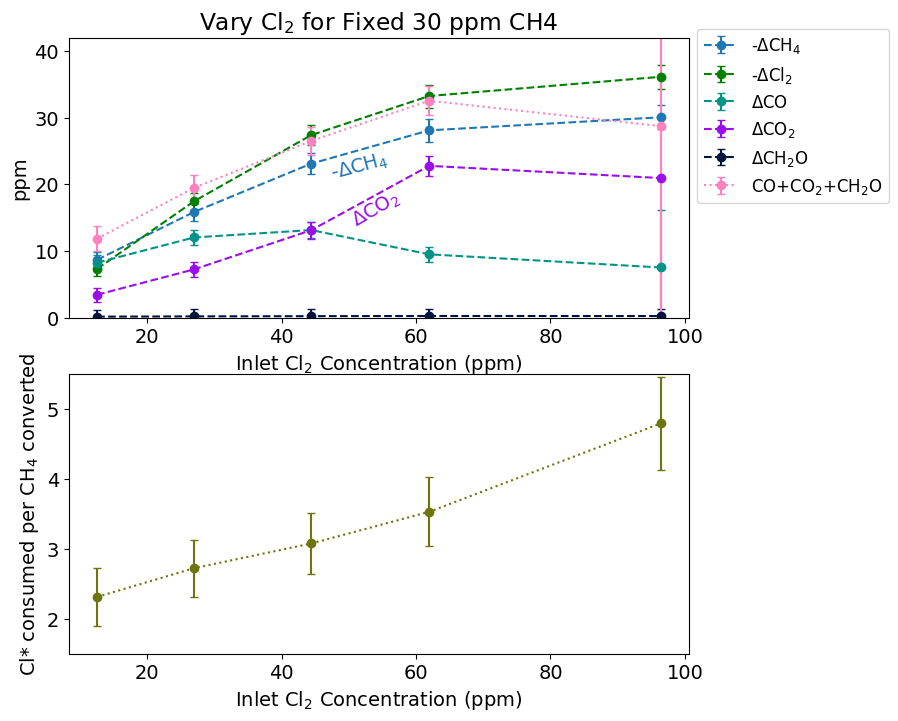

In [ ]:
importlib.reload(cl2_utils)
""" Data Extraction """

# UPDATE THIS TO MAKE USE OF THE NEW DATA

# Select data from only the the experiments we want
conversion_data_929 = pd.read_csv("../_exported_data/conversions_09-29_cl2_campaign_after_mfc_zero.csv")
all_conversion_data = conversion_data_929
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4"]#,"09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
#conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | 
#                                  (conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']>35)] # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 Node A (ppm) baseline',ascending=True)

# Extract the values and 95% CI's from the data
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
ch4_95_ci = conversion_data['Selected: CH4 (ppm) conversion 95% CI']
cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
cl2_conversion_95_ci = conversion_data['Selected: CH4 (ppm) conversion 95% CI']
inlet_cl2 = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']
co = conversion_data['FTIR: CO (ppm) bypass average']
co_95_ci = conversion_data['FTIR: CO (ppm) bypass average 95% CI']
co2 = conversion_data['FTIR: CO2 (ppm) bypass average']
co2_95_ci = conversion_data['FTIR: CO2 (ppm) bypass average 95% CI']
ch2o = conversion_data['FTIR: CH2O (ppm) bypass average']
ch2o_95_ci = conversion_data['FTIR: CH2O (ppm) bypass average 95% CI']

# Get the means and 95% CI for the sum of all of them
co_co2_ch2o_sum = co2+co+ch2o
co_co2_ch2o_95_ci = 2*np.sqrt((0.5*co2_95_ci)**2 + (0.5*co_95_ci)**2 + (0.5*ch2o_95_ci)**2)

""" Plotting and Cosmetics """
# Plot options
use_error_bars = True
show_products = True

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
cl2_utils.do_error_bar(ax1,default_properties,'CH4',inlet_cl2,ch4_conversions,(ch4_95_ci if use_error_bars else None))
cl2_utils.do_error_bar(ax1,default_properties,'Cl2',inlet_cl2,cl2_conversions,(cl2_conversion_95_ci if use_error_bars else None))
if show_products:
    cl2_utils.do_error_bar(ax1,default_properties,'CO',inlet_cl2,co,(co_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'CO2',inlet_cl2,co2,(co2_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'CH2O',inlet_cl2,ch2o,(ch2o_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'C1 sum',inlet_cl2,co_co2_ch2o_sum,(co_co2_ch2o_95_ci if use_error_bars else None))
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax1.set_ylim(0,42)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
(cl_budget,cl_budget_95_ci) = cl2_utils.get_cl_radical_budget(inlet_cl2)
cl_per_ch4 = cl_budget / ch4_conversions
cl2_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(cl_budget,cl_budget_95_ci,ch4_conversions,ch4_95_ci)
#cl2_per_ch4_95_ci = cl_budget_95_ci/ch4_conversions

cl2_utils.do_error_bar(ax2,default_properties,'Cl* efficiency',inlet_cl2,cl_per_ch4,(cl2_per_ch4_95_ci if use_error_bars else None))
ax2.set_ylabel("Cl* consumed per CH$_4$ converted")
ax2.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.5,5.5)

# Labeling
labels = (('CH4',47,20,15),
          ('CO2',50,13,30),)
cl2_utils.label_lines(ax1,default_properties,labels)

ax1.set_title("Vary Cl$_2$ for Fixed 30 ppm CH4")
plt.show()